<a href="https://colab.research.google.com/github/BrendenLatham/Data_Viz/blob/main/Masters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [ ]:
df = df[df['continent'].notna()]

I am going to be using the above data to recreate a graph comparing the current location of each country on it's pandemic curve relative to it's peak. It will examine the latest days reported new cases of covid-19 relative to the peak day of new cases

It will be a recreation of the similar graph located on this page https://graphics.reuters.com/world-coronavirus-tracker-and-maps/

First I want to see all the columns in this dataset

In [ ]:
df.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

This data is supposed to have been updated daily so I want to see the max new_cases for each country

In [ ]:
maxes = df.groupby('location').new_cases.agg('max')
maxes.head()

location
Afghanistan    3243.0
Albania        4789.0
Algeria        2521.0
Andorra        2313.0
Angola         5035.0
Name: new_cases, dtype: float64

Now I want to actually see the latest report for each country

In [ ]:
LatestReport = df.groupby('location').date.max()
LatestReport.head()

location
Afghanistan    2022-04-27
Albania        2022-04-27
Algeria        2022-04-27
Andorra        2022-04-27
Angola         2022-04-27
Name: date, dtype: object

If you look at all values it looks like some countries haven't been updated in a bit

This might cause problems but we shall see later on

I want to get a list of the countries that dont have yestardays data in

In [ ]:
non_current = (x for x in LatestReport if x != max(LatestReport))
non_current_list = []
for i in non_current:
  non_current_list.append(LatestReport[LatestReport == i].index[0])
non_current_list

['Guam',
 'Guernsey',
 'Jersey',
 'Nauru',
 'Niue',
 'Northern Cyprus',
 'Northern Mariana Islands',
 'Pitcairn',
 'Puerto Rico',
 'Sint Maarten (Dutch part)',
 'Tokelau',
 'Turkmenistan',
 'Tuvalu',
 'Puerto Rico',
 'Guam']

For these countries I will just use the most recent data

I will now create one dataframe that we will use for the graph

In [ ]:
locations = df.location.unique()
locations

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Faeroe Isl

In [ ]:
data1 = df.groupby('location', as_index = False).date.max()
data2 = df.groupby('location', as_index = False).new_cases.max().new_cases
data = pd.concat([data1,data2],axis = 1)
data.columns = ['location','date','max_new_cases']

In [ ]:
data_to_join = df[['location','date','new_cases']]
data

,location,date,max_new_cases
0,Afghanistan,2022-04-27,3243.0
1,Albania,2022-04-27,4789.0
2,Algeria,2022-04-27,2521.0
3,Andorra,2022-04-27,2313.0
4,Angola,2022-04-27,5035.0
...,...,...,...
225,Wallis and Futuna,2022-04-27,47.0
226,Western Sahara,2022-04-20,NaN
227,Yemen,2022-04-27,287.0
228,Zambia,2022-04-27,5555.0


In [ ]:
data = pd.merge(data, data_to_join, how = 'left', left_on = ['location','date'], right_on = ['location','date'])
data

,location,date,max_new_cases,new_cases
0,Afghanistan,2022-04-27,3243.0,40.0
1,Albania,2022-04-27,4789.0,67.0
2,Algeria,2022-04-27,2521.0,1.0
3,Andorra,2022-04-27,2313.0,0.0
4,Angola,2022-04-27,5035.0,0.0
...,...,...,...,...
225,Wallis and Futuna,2022-04-27,47.0,0.0
226,Western Sahara,2022-04-20,NaN,NaN
227,Yemen,2022-04-27,287.0,0.0
228,Zambia,2022-04-27,5555.0,NaN


In [ ]:
data['percent_of_max'] = data.new_cases/data.max_new_cases
data.head()

,location,date,max_new_cases,new_cases,percent_of_max
0,Afghanistan,2022-04-27,3243.0,40.0,0.012334
1,Albania,2022-04-27,4789.0,67.0,0.013990
2,Algeria,2022-04-27,2521.0,1.0,0.000397
3,Andorra,2022-04-27,2313.0,0.0,0.000000
4,Angola,2022-04-27,5035.0,0.0,0.000000


Now lets drop any null values and reorder by percent of max

In [ ]:
data.dropna(inplace=True)
data = data.sort_values('percent_of_max', ascending = False)
data.reset_index(drop=True, inplace=True)

Now for this next part I will need to sort the values by "percent of max"

Now for the visualization

<function matplotlib.pyplot.show>

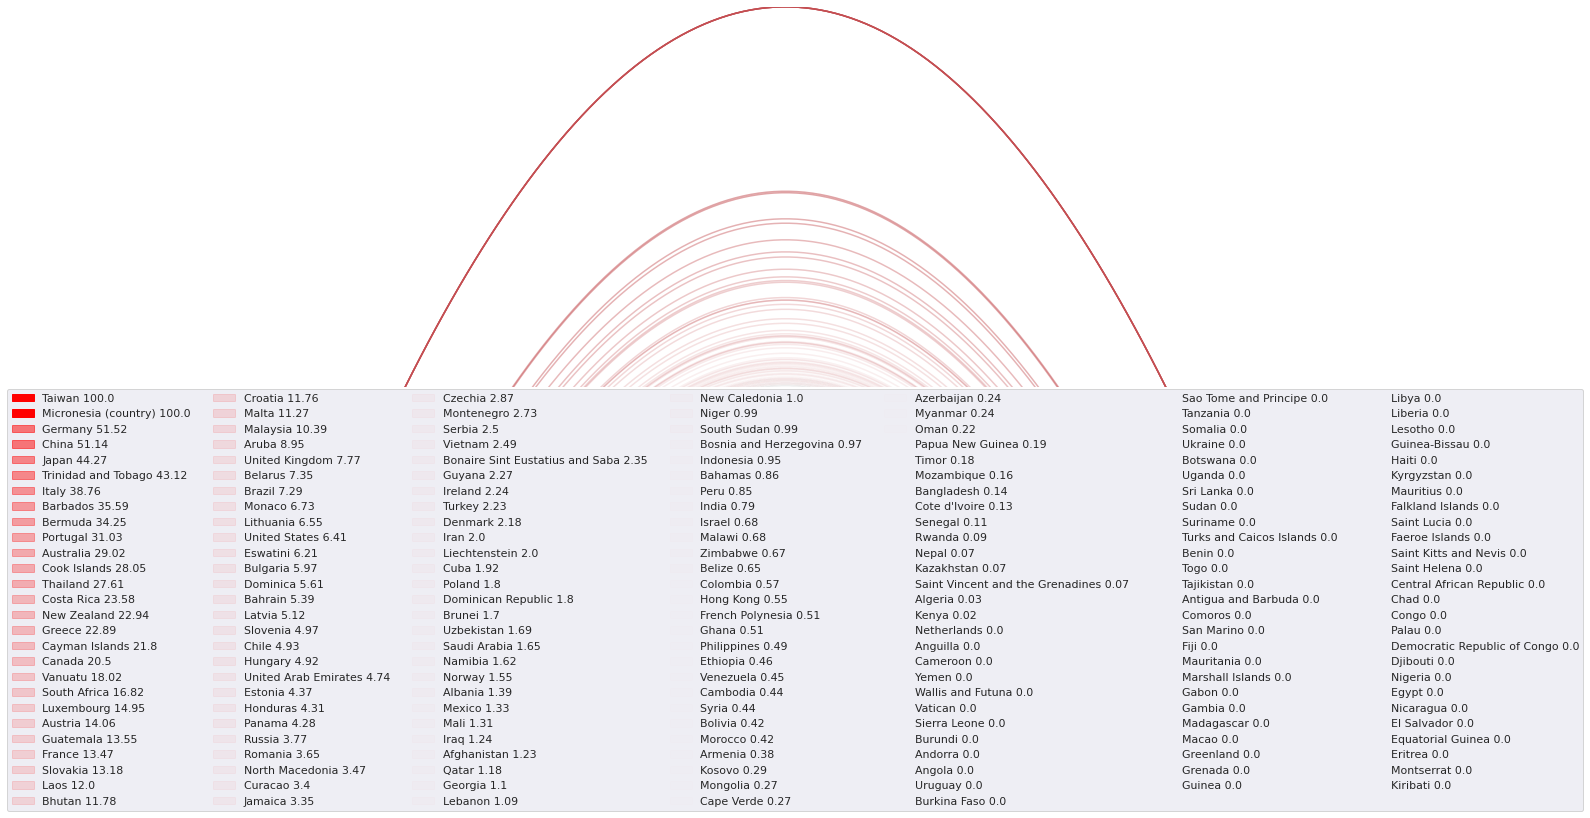

In [ ]:
x = np.linspace(-1,1,100)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.ylim(0,1)
plt.axis('off')
sns.set(rc={'figure.figsize':(15,7)})

for i in data['percent_of_max']:
  y = -x**2+i
  plt.plot(x,y,color='r', alpha = i)
y2 = -x**2+1
plt.plot(x,y2, color = 'r')

patches = []
for j in range(0,len(data['location']),1):
  patches.append(mpatches.Patch(color='red', alpha = data['percent_of_max'][j], label = data['location'][j]+' '+str(truncate(100*data['percent_of_max'][j],2))))
plt.legend(handles=patches, bbox_to_anchor=(1.46, .01), loc='upper right', ncol=7)


plt.show

It is worth noting that a percentage of 0 does not really mean no cases were reported. It just means it was less than .01%